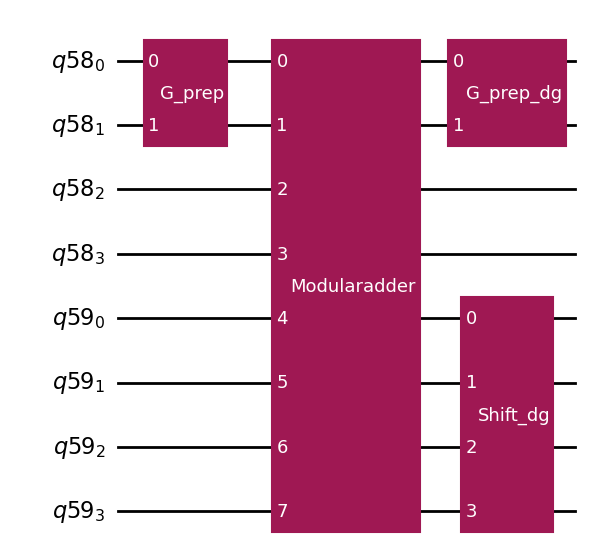

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor, ceil
from scipy.integrate import quad

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.circuit.library import StatePreparation, QFTGate, RYGate, ModularAdderGate 

# Block encoding of tridiagonal matrix B(dx,dt,nu)
# To enforce numerical stability we compute dt = scale * dx**2/(2*nu) where scale = 0.9 (this factor can be changed but must be less than 1). 

def Shift_gate(n):
    """
    n : number of qubits.
    
    Returns a gate implementing the shift operation  
    |k> --> |k+1 (mod 2**n)> in the computational basis.
    """
    qc = QuantumCircuit(n,name = 'Shift')
    for j in range(n-1):
        qc.mcx([k for k in range(n-1-j)],n-1-j)         # Using multi controlled NOT gates 
    qc.x(0)
    return qc.to_gate()
    
def Diffusion_prep(n,nu):
    """
    n: number of spatial qubits.
    nu: diffusion coefficient. 
    
    Returns a 2 qubit gate state preparation gate implementing 
    |0> --> sqrt(nu*dt/dx**2)|0> + sqrt(1-2*nu*dt/dx**2)|1> + sqrt(nu*dt/dx**2) |2>
    """
    dx = 1/2**n
    dt = 0.9*dx**2/(2*nu)              # We choose dt such that the stability criterion 1>2*nu*dt/(dx^2) is satisfied 

    a = 1-2*dt*nu/dx**2
    theta = np.arcsin(np.sqrt(a))   # The rotation angle needed to prepare sqrt(a) using an RY gate  

    qc = QuantumCircuit(2,name = 'G_prep')
    qc.ry(2*theta,0)
    qc.ch(0,1,ctrl_state = '0')          # Controlled Hadamard gate 
    return qc

def Block_encoding(n,nu):
    """
    n : number of spatial qubits
    nu : diffusion coefficent.
    
    Returns a circuit block encoding of the tridiagonal matrix with (1-2*nu*dt/dx**2) on the main diagonal
    and nu*dt/dx**2 on the two adjacent diagonals. The circuit has two registers qr1, qr2 both on n
    qubits and the matrix is encoded on the subspace |0...0> * C^(2**n).
    """ 
    # Setting up the circuit 
    qr1 = QuantumRegister(n)
    qr2 = QuantumRegister(n)
    qc = QuantumCircuit(qr1,qr2)
    
    # Preparing the needed gates 
    G = Diffusion_prep(n,nu)
    S = Shift_gate(n)
    adder = ModularAdderGate(n)
    
    # Constructing the circuit
    qc.append(G,qr1[:2])
    qc.append(adder,qr1[:]+qr2[:])
    qc.append(S.inverse(),qr2[:])
    qc.append(G.inverse(),qr1[:2])
    return qc 

def int_prep(k,n):
    # Simple circuit for preparing the computational basis state |k> on n qubits
    # Implements: |0> -- > |k> 
    qc = QuantumCircuit(n)
    r = 0 
    while k >0:
        if k % 2 == 1:
            qc.x(r)
            k = (k-1)//2
        else:
            k = k//2 
        r = r+1
    return qc

qc = Block_encoding(n = 4,nu = 0.02)
qc.draw('mpl')


In [34]:
# Testing the block encoding
# from qiskit_aer.primitives import SamplerV2

def test_BE(n,nu,k,shots = 10**4):
    """
    Function for testing the block encoding circuit
    Inputs
    n : number of spatial qubits
    nu : diffusion coefficent.
    k : computational basis state 
    shots: number of shots in the simulation 

    Prints: success rate, block-encoded matrix applied to computational state |k>, exact diagonal entries  
    """
    qr1 = QuantumRegister(n)
    qr2 = QuantumRegister(n)
    cr1 = ClassicalRegister(n)
    cr2 = ClassicalRegister(n) 
    qc = QuantumCircuit(qr1,qr2,cr1,cr2)
    qc.append(int_prep(k,n),qr2)

    qc.append(BE(n,nu),qr1[:]+qr2[:])

    # Measurements
    qc.measure(qr1,cr1)
    qc.measure(qr2,cr2)
    
    # qc = qc.decompose().decompose()
    # Simulating the circuit with the AerSimulator 
    backend = AerSimulator()
    tqc = transpile(qc, backend,optimization_level=0)
    result = backend.run(tqc,shots = shots).result()
    counts = result.get_counts(tqc)

    # Postselection
    select = n*'0'
    total = 0                      # Tracks the number of successfull outcomes
    z = np.zeros(2**n)                # The results are encoded in z 
    for key in counts:
        L = key.split()
        if L[1] == select:
            z[int(L[0],2)] = np.sqrt(counts[key]/shots)    # By construction all amplitudes are positive real numbers
            total += counts[key]                           # so this actually recovers them!
    success_rate = total/shots
    print('Success rate =', success_rate)
    print("Simulation output: ",z) 
    dx = 1/2**n
    dt = 0.9*dx**2/(2*nu)              # We choose dt such that the stability criterion 1>2*nu*dt/(dx^2) is satisfied 
    a = 1-2*dt*nu/(dx**2)
    b = dt*nu/(dx**2)
    print("Exact diagonal entries:", b,a,b)

test_BE(n=3,nu = 0.02,k = 1,shots = 10**6)

Success rate = 0.41479
Simulation output:  [0.44978328 0.09950377 0.45009332 0.         0.         0.
 0.         0.        ]
Exact diagonal entries: 0.45 0.09999999999999998 0.45


In [ ]:
# Composition of block encoding in a sample run. Does state prep work? 

The maximal error is: 0.09995251681803619


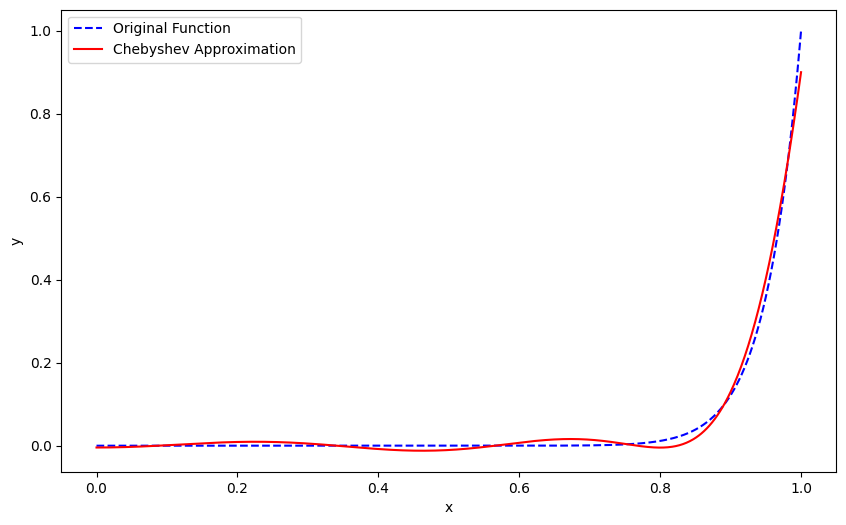

[sym_qsp] Iterative optimization to err 1.000e-12 or max_iter 100.
iter: 001 --- err: 1.200e-01
iter: 002 --- err: 1.484e-02
iter: 003 --- err: 4.419e-04
iter: 004 --- err: 4.491e-07
iter: 005 --- err: 4.659e-13
[sym_qsp] Stop criteria satisfied.


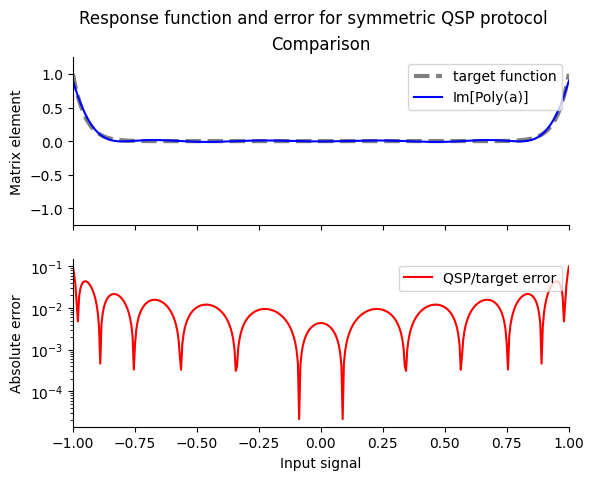

In [ ]:
from pyqsp import angle_sequence, response, poly
import numpy as np
import cvxpy as cp
from numpy.polynomial.chebyshev import chebpts1, Chebyshev
from math import comb
import matplotlib.pyplot as plt

""" 
Requirements: cvxpy, pyqsp (install with pip)

Functions: cvx_poly_coef, Angles_symQSP

cvx_poly_coef uses the cvxpy convex optimizer to find the Chebyshev polynomial best approximating
a given target function. 

Angles_symQSP uses the pyqsp implementation of qsp_sym to find an optimal angle sequence for a
given Chebyshev coefficient sequence. 
"""  

def cvx_poly_coef(targ_f,interval, deg,epsil = 0.1, npts=200, plot=False):
    """
    targ_f: target function to be approximated. Should be odd or even and bounded by 1 on interval.
    interval: of the form [a,b] contained in [0,1].
    deg: degree of polynomial approximation.
    epsil: Desired error treshold. The resulting error tends to be much better provided the target function
           is bounded away from 1,-1 on the interval. 
    npts: number of Chebyshev points used in the optimizations.
    plot: If True, the obtained approximation is plotted against the target function and the maximal error
          is printed. 
    
    Returns: Array coef_full of consisting of the Chebyshev coefficients of the computed approximation.
            The length is deg+1
    """

    objnorm = np.inf
    parity = deg % 2

    # Generate Chebyshev points
    a, b = interval
    xpts = 0.5 * (a + b) + 0.5 * (b - a) * chebpts1(2 * npts)    # maps [-1,1] onto [a,b]
    npts = len(xpts)

    # Prepare Chebyshev polynomials
    n_coef = int(np.floor(deg/2)+1)

    Ax = np.zeros((npts, n_coef))
    for k in range(1,n_coef+1):
        Tcheb = Chebyshev.basis(2*(k-1)+parity)
        Ax[:,k-1] = Tcheb(xpts)

    # Use CVXPY to optimize coefficients
    coef = cp.Variable(n_coef)
    y = cp.Variable(npts)

    constraints = [
        y == Ax @ coef,
        y >= -(1 - epsil),
        y <= (1 - epsil),
    ]
    objective = cp.Minimize(cp.norm(y - targ_f(xpts), objnorm))
    problem = cp.Problem(objective, constraints)
    problem.solve()

    c = np.array(coef.value)  # Optimal coefficients

    coef_full = np.zeros(deg + 1)
    if parity == 0:
        coef_full[::2] = c
    else:
        coef_full[1::2] = c
    
    if plot:
        # Create the Chebyshev polynomial using these coefficients
        cheb_poly = Chebyshev(coef_full)
    
        # Checking max error
        x_data = np.linspace(a,b,2*npts)
        targ_val = targ_f(x_data)
        cheb_val = cheb_poly(x_data)
        abs_err = max(abs(targ_f(x_data)-cheb_poly(x_data)))
        print('The maximal error is:',abs_err)

        # Plot the results
        plt.figure(figsize=(10, 6))

        # Plot the original function
        plt.plot(x_data, targ_val, label="Original Function", color='blue', linestyle='dashed')

        # Plot the Chebyshev polynomial approximation
        plt.plot(x_data, cheb_val, label="Chebyshev Approximation", color='red')

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

    return coef_full
    
def Angles_symQSP(coef,resp_plot = False,targ_f=None,QSVT_format = True):
    """
    Takes an array of Chebyshev coefficients as input and returns the QSVT angle sequence.
    If resp_plot = True, angle response is plotted against the input polynomial. 
    """

    (phiset, red_phiset, parity) = angle_sequence.QuantumSignalProcessingPhases(
        poly=coef,
        eps=1e-6,
        suc=1 - 1e-6,
        signal_operator="Wx",
        measurement=None,
        tolerance=0.01,
        method="sym_qsp",
        chebyshev_basis=True
    )

    # Plot response
    if resp_plot and targ_f:
        response.PlotQSPResponse(
            phiset,
            target=targ_f,
            signal_operator="Wx",
            measurement="z",
            sym_qsp=True,
            simul_error_plot=True,
            title="Comparison"
        )
    
    if QSVT_format:
        n = len(phiset)-1
        Phi = np.zeros(n)
        Phi[1:n] = phiset[1:n]-np.pi/2
        Phi[0] = phiset[0]+phiset[-1]+((n-2)%4)*np.pi/2
        # In the ususal QSP to QSVT one adds (n-1) pi/2. Here (n-2) is needed. 
        # In the symmetric qsp protocol the target polynomial is encoded as Im P wrt. the standard pair (P,Q)
        # where the symmetry forces Q = Q* to be real. In my previous work the target function is Re P instead
        # and in that case one uses n-1 instead. 
    else: 
        Phi = phiset 
    return Phi

targ_f = lambda x:x**20 
coef = cvx_poly_coef(targ_f = targ_f,interval = [0,1], deg = 12,epsil = 0.1, npts=200, plot=True)
Phi = Angles_symQSP(coef,resp_plot = True,targ_f=targ_f,QSVT_format = True)